 # Import Library

In [2]:


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
import matplotlib.pyplot as plt

print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

# Check if TensorFlow is built with CUDA (GPU) support
print("Is TensorFlow built with CUDA support:", tf.test.is_built_with_cuda())

# List available physical devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

# Check if TensorFlow can access the GPU
if physical_devices:
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is not using the GPU.")

NumPy version: 1.26.4
TensorFlow version: 2.10.1
Is TensorFlow built with CUDA support: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using the GPU.


## Make train,val,test data sets

In [4]:
import os
import shutil
import random

image_dir = "MaskImages"
mask_dir = "NewMask"
output_dir = "Dataset"

for split in ["train", "test"]:
    os.makedirs(os.path.join(output_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, "masks"), exist_ok=True)

images = [f for f in os.listdir(image_dir) if f.endswith(".png")]

random.shuffle(images)

train_split = int(0.85*len(images))


train_images = images[:train_split]
test_images = images[train_split:]


def move_files(images_type,split_type):
    for image in images_type:
        image_path = os.path.join(image_dir, image)
        mask_path = os.path.join(mask_dir,image.replace(".png","_mask.png"))

        test_img_path = os.path.join(output_dir,split_type,"images",image)
        test_mask_path = os.path.join(output_dir,split_type,"masks",image.replace(".png","_mask.png"))  

        shutil.copy(image_path,test_img_path)
        shutil.copy(mask_path,test_mask_path)

move_files(train_images,"train")
move_files(test_images,"test")



In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

print("Number of training images:", len(train_images))
print("Number of test images:", len(test_images))

print("shape of image:",load_img(os.path.join(output_dir,"train","images",train_images[0])).size)
print("shape of mask:",load_img(os.path.join(output_dir,"train","masks",train_images[0].replace(".png","_mask.png"))).size)

Number of training images: 385
Number of test images: 69
shape of image: (2592, 1944)
shape of mask: (2592, 1944)


## Data pre processing ang augmentation

train_images shape: (385, 256, 256, 3)
train_masks shape: (385, 256, 256, 1)


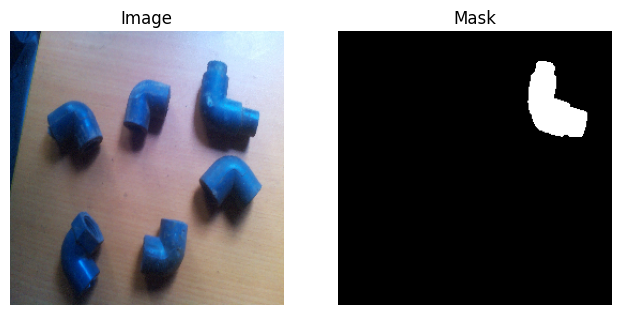

In [6]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt

train_img_dir = "Dataset/train/images"
train_mask_dir = "Dataset/train/masks"
img_size = (256, 256)

def load_data(image_dir, mask_dir, img_size):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, image_file.replace(".png", "_mask.png"))

        image = load_img(image_path, target_size=img_size)
        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

        image = img_to_array(image) / 255.0  # Normalize images
        mask = img_to_array(mask)/255.0  # Normalize masks

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

train_images, train_masks = load_data(train_img_dir, train_mask_dir, img_size)

print("train_images shape:", train_images.shape)
print("train_masks shape:", train_masks.shape)

#plot sample
def plot_sample(image, mask, pred=None):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[:, :, 0], cmap="gray")
    plt.axis("off")
    plt.title("Mask")

    if pred is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(pred)
        plt.axis("off")
        plt.title("Prediction")

    plt.show()

plot_sample(train_images[4], train_masks[4])

In [ ]:
%pip install scikit-learn

In [21]:

from sklearn.model_selection import train_test_split

# Split dataset into train and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42
)
print("Number of training images:", len(train_images))

# Define ImageDataGenerator for images
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Define ImageDataGenerator for masks (no intensity change)
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"  # Ensures segmentation labels don't get interpolated
)

# Create generators that apply the same transformation to images and masks
def create_generator(images, masks, batch_size=8):
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=42)

    for img, mask in zip(image_generator, mask_generator):
        yield img, mask  # Ensures images and masks are aligned

# Create final generators
train_generator = create_generator(train_images, train_masks, batch_size=8)
val_generator = create_generator(val_images, val_masks, batch_size=8)






Number of training images: 279


without Augmentation


In [36]:
from sklearn.model_selection import train_test_split

# Split dataset into train and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42
)

# Create final generators without augmentation
def image_mask_generator(images, masks, batch_size):
    for i in range(0, len(images), batch_size):
        yield images[i:i+batch_size], masks[i:i+batch_size]

# Define batch size
batch_size = 8

# Create training and validation generators
train_generator = image_mask_generator(train_images, train_masks, batch_size)
val_generator = image_mask_generator(val_images, val_masks, batch_size)

# Print dataset shapes
print("Train images shape:", train_images.shape)
print("Train masks shape:", train_masks.shape)
print("Validation images shape:", val_images.shape)
print("Validation masks shape:", val_masks.shape)

Train images shape: (346, 256, 256, 3)
Train masks shape: (346, 256, 256, 1)
Validation images shape: (39, 256, 256, 3)
Validation masks shape: (39, 256, 256, 1)


# UNET Architecture

In [18]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

def unet_model(input_shape= (256,256,3),num_classes = 2, learning_rate = 0.001):

    input = Input(input_shape)

    c1 = Conv2D(64,(3,3),activation="relu",padding="same")(input)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64,(3,3),activation="relu",padding="same")(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512,(3,3),activation = 'relu',padding = 'same')(c4)
    c4 = BatchNormalization()(c4)

    u5 = UpSampling2D((2,2))(c4)
    u5 = concatenate([u5,c3])
    c5 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256,(3,3),activation = 'relu',padding = 'same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = UpSampling2D((2,2))(c5)
    u6 = concatenate([u6,c2])
    c6 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128,(3,3),activation = 'relu',padding = 'same')(c6)
    c6 = BatchNormalization()(c6)
    
    u7 = UpSampling2D((2,2))(c6)
    u7 = concatenate([u7,c1])
    c7 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64,(3,3),activation = 'relu',padding = 'same')(c7)
    c7 = BatchNormalization()(c7)

    output = Conv2D(num_classes,(1,1),activation = 'softmax')(c7)

    optimizer = Adam(learning_rate = learning_rate)
    model = Model(input,output)
    model.compile(optimizer = optimizer ,loss = 'categorical_crossentropy',metrics = ['accuracy'])  

    return model

model = unet_model(input_shape=(256,256,3), num_classes=2, learning_rate=0.0001)
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 256, 256, 64  256        ['conv2d_15[0][0]']              
 ormalization)                  )                                                           

In [22]:
import scipy

history = model.fit(
    train_generator,
    epochs=16,
    steps_per_epoch=len(train_images) // 8,
    validation_data=val_generator,
    validation_steps=len(val_images) // 8
)

Epoch 1/16
34/34 [==============================] - 13s 383ms/step - loss: 0.0464 - accuracy: 0.4727 - val_loss: 0.0460 - val_accuracy: 0.9999
Epoch 2/16
34/34 [==============================] - 13s 384ms/step - loss: 0.0446 - accuracy: 0.4689 - val_loss: 0.0467 - val_accuracy: 0.0426
Epoch 3/16
34/34 [==============================] - 13s 398ms/step - loss: 0.0465 - accuracy: 0.4548 - val_loss: 0.0454 - val_accuracy: 0.0189
Epoch 4/16
34/34 [==============================] - 13s 391ms/step - loss: 0.0430 - accuracy: 0.4151 - val_loss: 0.0442 - val_accuracy: 0.0151
Epoch 5/16
34/34 [==============================] - 15s 453ms/step - loss: 0.0453 - accuracy: 0.4161 - val_loss: 0.0444 - val_accuracy: 0.3449
Epoch 6/16
34/34 [==============================] - 15s 428ms/step - loss: 0.0462 - accuracy: 0.3548 - val_loss: 0.0476 - val_accuracy: 0.3472
Epoch 7/16
34/34 [==============================] - 14s 411ms/step - loss: 0.0459 - accuracy: 0.3804 - val_loss: 0.0446 - val_accuracy: 0.3544

In [63]:
from sklearn.model_selection import train_test_split

# # Split dataset into train and validation sets
# train_images, val_images, train_masks, val_masks = train_test_split(
#     train_images, train_masks, test_size=0.1, random_state=42
# )

# Create infinite generators
def image_mask_generator(images, masks, batch_size):
    while True:  # Infinite loop
        for i in range(0, len(images), batch_size):
            yield images[i:i+batch_size], masks[i:i+batch_size]

# Define batch size
batch_size = 8

# Create training and validation generators
train_generator = image_mask_generator(train_images, train_masks, batch_size)
val_generator = image_mask_generator(val_images, val_masks, batch_size)

# Calculate steps per epoch
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(val_images) // batch_size

# Print dataset shapes
print("Train images shape:", train_images.shape)
print("Train masks shape:", train_masks.shape)
print("Validation images shape:", val_images.shape)
print("Validation masks shape:", val_masks.shape)

# Train the model
history = model.fit(
    train_generator,
    epochs=18,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Train images shape: (346, 256, 256, 3)
Train masks shape: (346, 256, 256, 1)
Validation images shape: (39, 256, 256, 3)
Validation masks shape: (39, 256, 256, 1)
Epoch 1/18
43/43 [==============================] - 17s 379ms/step - loss: 0.0475 - accuracy: 0.4219 - val_loss: 0.0580 - val_accuracy: 0.0143
Epoch 2/18
35/43 [=======================>......] - ETA: 2s - loss: 0.0475 - accuracy: 0.4476

KeyboardInterrupt: 

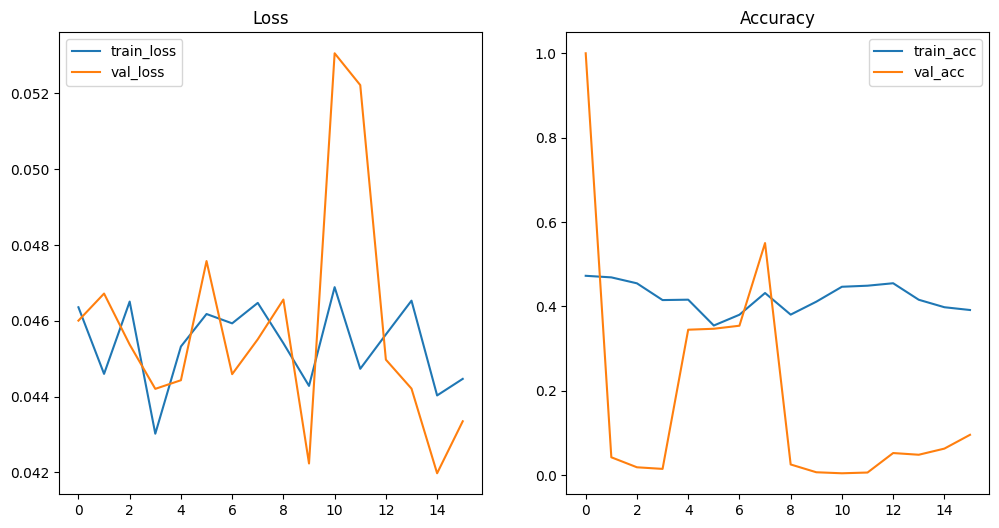

In [23]:
#PLOT LOSS AND ACCURACY
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()

plt.title("Accuracy")
plt.show()



test_images shape: (69, 256, 256, 3)
test_masks shape: (69, 256, 256, 1)
1/1 [==============================] - 0s 51ms/step


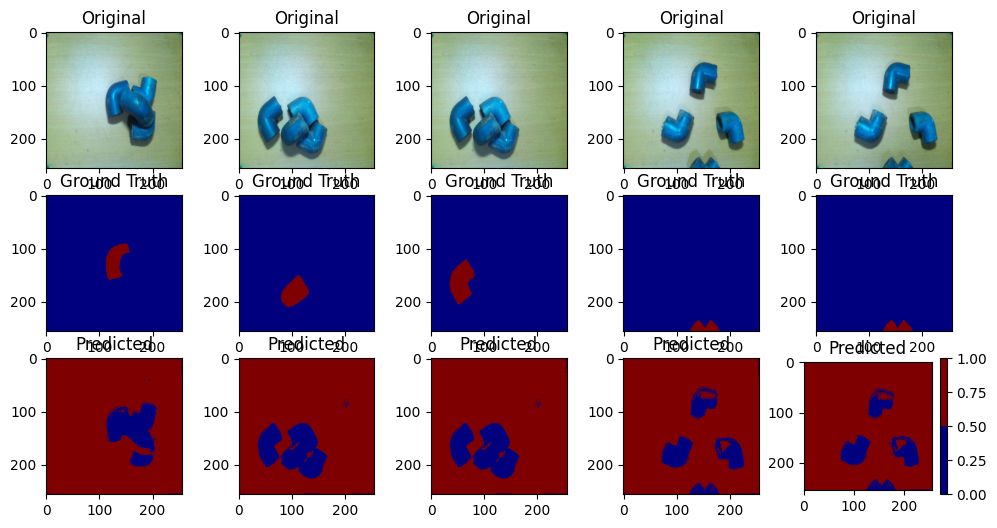

In [26]:
test_img_dir = "Dataset/test/images"
test_mask_dir = "Dataset/test/masks"
img_size = (256, 256)

test_images, test_masks = load_data(test_img_dir, test_mask_dir, img_size)
print("test_images shape:", test_images.shape)
print("test_masks shape:", test_masks.shape)

test_images = test_images[64:69] 
test_masks = test_masks[64:69] # Select first 5 images for testing
# Get model predictions (Softmax output)
preds = model.predict(test_images)  # Shape: (5, H, W, num_classes)

# Convert Softmax probabilities to class labels
pred_masks = np.argmax(preds, axis=-1)  # Shape: (5, H, W) -> Class labels

# Define a colormap for multi-class visualization
num_classes = preds.shape[-1]
cmap = plt.get_cmap("jet", num_classes)  # "jet" gives distinct colors

# Plot original images, ground truth, and predictions
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(test_images[i])  # Original image
    plt.title("Original")

    plt.subplot(3, 5, i+6)
    plt.imshow(test_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=num_classes-1)  # Ground truth
    plt.title("Ground Truth")

    plt.subplot(3, 5, i+11)
    plt.imshow(pred_masks[i], cmap=cmap, vmin=0, vmax=num_classes-1)  # Predicted segmentation
    plt.title("Predicted")

plt.colorbar()
plt.show() 

In [ ]:
test_img_dir = "Dataset/test/images"
test_mask_dir = "Dataset/test/masks"
img_size = (256, 256)

# Load test data
test_images, test_masks = load_data(test_img_dir, test_mask_dir, img_size)
print("test_images shape:", test_images.shape)
print("test_masks shape:", test_masks.shape)

# Get model predictions (Sigmoid output)
preds = model.predict(test_images[1:6])  # Shape: (5, H, W, 1)

# Convert Sigmoid probabilities to binary masks
threshold = 0.5
pred_masks = (preds > threshold).astype(np.uint8)  # Shape: (5, H, W, 1)

# Plot original images, ground truth, and predictions
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(test_images[i])  # Original image
    plt.title("Original")

    plt.subplot(3, 5, i+8)
    plt.imshow(test_masks[i].squeeze(), cmap="gray")  # Ground truth
    plt.title("Ground Truth")

    plt.subplot(3, 5, i+15)
    plt.imshow(pred_masks[i].squeeze(), cmap="gray")  # Predicted segmentation
    plt.title("Predicted")

plt.show()